In [196]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import re
from nltk.corpus import stopwords
from pymystem3 import Mystem
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from nltk import FreqDist
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import  ward, dendrogram
from gensim import corpora, models
import gensim
from gensim.models.doc2vec import *
from sklearn.pipeline import Pipeline

In [ ]:
import pyLDAvis.gensim
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

In [15]:
df = pd.read_csv('./lenta-ru-news.csv', usecols = ['title', 'text', 'topic', 'tags'])
df.dropna(subset=['tags', 'topic'], inplace = True)
df.shape

(712834, 4)

In [9]:
df.head(10)

,title,text,topic,tags
0,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия,Общество
1,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт,Зимние виды
2,Обнаружено самое счастливое место на планете,Сотрудники социальной сети Instagram проанализ...,Путешествия,Мир
3,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир,Политика
4,Хакеры рассказали о планах Великобритании зами...,Хакерская группировка Anonymous опубликовала н...,Мир,Общество
5,Архиепископ канонической УПЦ отказался прийти ...,Архиепископ канонической Украинской православн...,Бывший СССР,Украина
6,Российскую молодежь предложили обучать духовны...,Российская молодежь лучше усвоит духовные ценн...,Интернет и СМИ,Coцсети
7,Полицейские из Солсбери описали одеревеневшего...,"Полицейские Алекс Коллинс и Трейси Холлоуэй, о...",Мир,Общество
8,Полет российских бомбардировщиков над Карибски...,Минобороны опубликовало на YouTube видео полет...,Мир,Политика
9,В Минобороны раскрыли многомиллионные хищения ...,Директора завода «Электроприбор» Муталиба Эмир...,Силовые структуры,Следствие и суд


In [7]:
df['topic'].value_counts()

Россия               155081
Мир                  136680
Экономика             76433
Спорт                 57902
Культура              53537
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44433
Из жизни              27519
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64

In [8]:
df['tags'].value_counts()

Все                  453760
Политика              33220
Общество              27560
Украина               17934
Происшествия          15972
Футбол                13128
Госэкономика          12869
Кино                   9109
Бизнес                 8224
Интернет               7945
Наука                  6975
Следствие и суд        6825
Музыка                 5823
Люди                   5184
Преступность           4737
Квартира               3759
Космос                 3622
События                3161
Конфликты              3136
ТВ и радио             3028
Coцсети                2924
Летние виды            2893
Деловой климат         2656
Регионы                2639
Криминал               2550
Явления                2523
Бокс и ММА             2443
Звери                  2278
Город                  2247
Гаджеты                2183
                      ...  
Софт                    652
Мнения                  615
Мемы                    477
Вирусные ролики         474
Еда                 

Оставим только тексты с 5 тегами:

In [27]:
tags = ['Космос', 'Политика', 'Кино', 'Футбол', 'Интернет']
df = df.loc[df['tags'].isin(tags)]
df.shape

(67024, 4)

__Проведем стандартную предобработку текста:__

In [39]:
regex = re.compile("[А-Яа-я]+")
def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return [l for l in m.lemmatize(text) if l.isalpha()]
    except:
        return []

def preprocessing(text):
    words = words_only(text)
    no_stopwords = remove_stopwords(words)
    lemmas = lemmatize(no_stopwords)
    return(lemmas)

In [40]:
s = np.array(df.text)[0]
print(s)
preprocessing(s)

С начала расследования российского вмешательства в выборы власти США потратили более 25 миллионов долларов. Об этом сообщает Associated Press со ссылкой на отчет Министерства юстиции США. В документе содержатся данные о расходах на следствие с апреля по сентябрь 2018 года. За эти полгода было потрачено 4,6 миллиона долларов, из которых почти 3 миллиона долларов ушли на зарплату сотрудников, 580 тысяч — на поездки и сопутствующие расходы. Ранее Минюст США уже публиковал отчеты о затратах на дело о российском вмешательстве за предыдущие месяцы. 11 декабря расследование спецпрокурора Робера Мюллера показало, что по меньшей мере 14 человек из окружения президента США Дональда Трампа контактировали с россиянами во время его избирательной кампании и последующего переходного периода перед вступлением в должность главы государства. Мюллер с 2017 года ведет дело о якобы российском вмешательстве в американские выборы в 2016-м. Перед ним поставлена задача выяснить, был ли сговор между штабом Трам

['с',
 'начало',
 'расследование',
 'российский',
 'вмешательство',
 'выборы',
 'власть',
 'сша',
 'потратить',
 'миллион',
 'доллар',
 'об',
 'сообщать',
 'ссылка',
 'отчет',
 'министерство',
 'юстиция',
 'сша',
 'в',
 'документ',
 'содержаться',
 'данные',
 'расход',
 'следствие',
 'апрель',
 'сентябрь',
 'год',
 'за',
 'полгода',
 'потратить',
 'миллион',
 'доллар',
 'который',
 'миллион',
 'доллар',
 'уходить',
 'зарплата',
 'сотрудник',
 'тысяча',
 'поездка',
 'сопутствующий',
 'расход',
 'ранее',
 'минюст',
 'сша',
 'публиковать',
 'отчет',
 'затрата',
 'дело',
 'российский',
 'вмешательство',
 'предыдущий',
 'месяц',
 'декабрь',
 'расследование',
 'спецпрокурор',
 'робер',
 'мюллер',
 'показывать',
 'меньший',
 'мера',
 'человек',
 'окружение',
 'президент',
 'сша',
 'дональд',
 'трамп',
 'контактировать',
 'россиянин',
 'время',
 'избирательный',
 'кампания',
 'последующий',
 'переходный',
 'период',
 'вступление',
 'должность',
 'глава',
 'государство',
 'мюллер',
 'год',
 'ве

In [41]:
%time df['lemmas'] = df.text.apply(lambda x: preprocessing(x))

CPU times: user 59.8 s, sys: 4.08 s, total: 1min 3s
Wall time: 6min 19s


In [42]:
df.head()

,title,text,topic,tags,lemmas
3,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир,Политика,"[с, начало, расследование, российский, вмешате..."
8,Полет российских бомбардировщиков над Карибски...,Минобороны опубликовало на YouTube видео полет...,Мир,Политика,"[минобороны, опубликовывать, видео, полет, рос..."
10,Британцам придется заплатить за путешествия по...,Жители Великобритании будут платить семь евро ...,Мир,Политика,"[житель, великобритания, быть, платить, семь, ..."
15,Бутину допросят в США по новому уголовному делу,"Россиянка Мария Бутина, судимая в США по обвин...",Мир,Политика,"[россиянка, мария, бутин, судить, сша, обвинен..."
17,Пентагон проигнорировал обращение России по ра...,Пентагон проигнорировал обращение министра обо...,Мир,Политика,"[пентагон, проигнорировать, обращение, министр..."


__Тематическое моделирование__

In [96]:
dictionary = corpora.Dictionary(df.lemmas)
corpus = [dictionary.doc2bow(text) for text in df.lemmas]

In [101]:
%time ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)

CPU times: user 12min 9s, sys: 2.95 s, total: 12min 12s
Wall time: 12min 18s


In [104]:
ldamodel.print_topics(num_topics=5, num_words=4)

[(0, '0.017*"матч" + 0.013*"клуб" + 0.013*"год" + 0.012*"команда"'),
 (1, '0.013*"сша" + 0.012*"страна" + 0.012*"россия" + 0.009*"в"'),
 (2, '0.020*"фильм" + 0.019*"год" + 0.011*"который" + 0.011*"в"'),
 (3, '0.013*"год" + 0.010*"в" + 0.010*"который" + 0.008*"россия"'),
 (4, '0.015*"год" + 0.010*"компания" + 0.010*"который" + 0.009*"в"')]

In [106]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

__Задание:__

Попробуйте обучить LDA только на существительных: очистите корпус от всех прочих частей речи и обучите новую модель.

In [ ]:
#...

__Обучим модель W2V:__

In [43]:
%%time

model = Word2Vec(df.lemmas, size=100, window=3, min_count=20, workers=4)

CPU times: user 1min 31s, sys: 675 ms, total: 1min 31s
Wall time: 29.2 s


Обученную модель можно сохранить и загружать:

In [45]:
model.save("word2v.model")
model = Word2Vec.load("word2v.model")

In [46]:
model['новость']

array([ 0.6856265 ,  0.43733162,  1.8219863 ,  0.9792097 , -0.69469607,
       -4.0235944 , -0.47196308, -2.878171  ,  0.6005986 , -0.8666903 ,
       -0.37237743,  1.2785008 , -0.08721814,  0.39217427,  2.6045525 ,
        0.7849575 ,  1.329916  , -0.53858656,  0.9038717 ,  0.5136568 ,
        2.069874  , -0.8411489 , -2.976972  , -2.2491856 , -1.1766189 ,
       -3.5134115 , -0.33744666,  0.4120404 ,  1.7548164 ,  0.49089828,
       -0.83869797, -1.3260024 ,  0.05849302,  0.7447891 ,  1.4209667 ,
        0.76038915,  1.7904868 ,  1.9905785 , -0.6051733 , -0.6394281 ,
        1.7727034 , -2.3509905 ,  0.16773558,  4.0668993 ,  0.461633  ,
       -0.5499211 ,  0.48085317,  1.6680351 ,  1.8996018 , -0.5557136 ,
       -1.024042  ,  0.5278655 , -0.02277004, -3.3332524 , -1.7418431 ,
       -1.4901512 , -1.2176168 , -0.07213689,  0.6587614 , -0.8020942 ,
       -1.4735061 , -1.134334  , -1.7224991 ,  1.9231333 , -1.2323188 ,
       -0.4331428 ,  0.5218385 ,  3.2315004 , -1.3179443 , -0.69

In [47]:
model['лалала']

KeyError: "word 'лалала' not in vocabulary"

Как проверить качество полученной модели?

In [50]:
model.most_similar("сайт")

[('страница', 0.7019076347351074),
 ('аккаунт', 0.6853137016296387),
 ('блог', 0.652167558670044),
 ('портал', 0.6481700539588928),
 ('твиттер', 0.5552785396575928),
 ('ресурс', 0.538398802280426),
 ('микроблога', 0.5265777111053467),
 ('видеохостинг', 0.49354273080825806),
 ('ресурсы', 0.47274255752563477),
 ('страничка', 0.4490850269794464)]

In [64]:
model.most_similar("еда")

[('пицца', 0.7705270051956177),
 ('мясо', 0.7683227062225342),
 ('напиток', 0.7635010480880737),
 ('телевизор', 0.7305836081504822),
 ('посылка', 0.7302168011665344),
 ('куриный', 0.7288140654563904),
 ('молоко', 0.7247328162193298),
 ('косметика', 0.7236729860305786),
 ('чипсы', 0.7224284410476685),
 ('чай', 0.7218098640441895)]

In [72]:
model.most_similar(positive=["путин","сша"], negative=["обама"])

[('украина', 0.5262073278427124),
 ('чижов', 0.5154954791069031),
 ('кожин', 0.5146806836128235),
 ('сафронок', 0.49275264143943787),
 ('турция', 0.48102807998657227),
 ('вольфович', 0.4669296145439148),
 ('познер', 0.46405088901519775),
 ('мединский', 0.460644006729126),
 ('комоед', 0.45179420709609985),
 ('москва', 0.45080798864364624)]

In [55]:
model.doesnt_match("планета космос байконур париж".split())

'париж'

In [52]:
model.doesnt_match("трамп путин маск обама меркель".split())

'маск'

__Визуализируем полученное пространство векторов:__

In [75]:
top_words = []

fd = FreqDist()
for text in tqdm(df.lemmas):
    fd.update(text)
for i in fd.most_common(1000):
    top_words.append(i[0])
print(top_words[:15])

HBox(children=(IntProgress(value=0, max=67024), HTML(value='')))


['год', 'в', 'который', 'россия', 'сообщать', 'президент', 'заявлять', 'об', 'российский', 'сша', 'страна', 'по', 'свой', 'время', 'становиться']


In [80]:
top_words = [w for w in top_words if len(w) > 4]
len(top_words)

842

In [81]:
top_words_vec = model[top_words]

__t-SNE__

In [82]:
tsne = TSNE(n_components=2, random_state=0)

%time top_words_tsne = tsne.fit_transform(top_words_vec)

CPU times: user 16.4 s, sys: 1.44 s, total: 17.8 s
Wall time: 17.9 s


In [86]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

__PCA__

In [87]:
pca = PCA(n_components=2)
%time pca_words = pca.fit_transform(top_words_vec)

CPU times: user 6.33 ms, sys: 28 ms, total: 34.3 ms
Wall time: 50.6 ms


In [89]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec PCA for most common words")

source = ColumnDataSource(data=dict(x1=pca_words[:,0],
                                    x2=pca_words[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

__Иерархическая кластеризация слов__

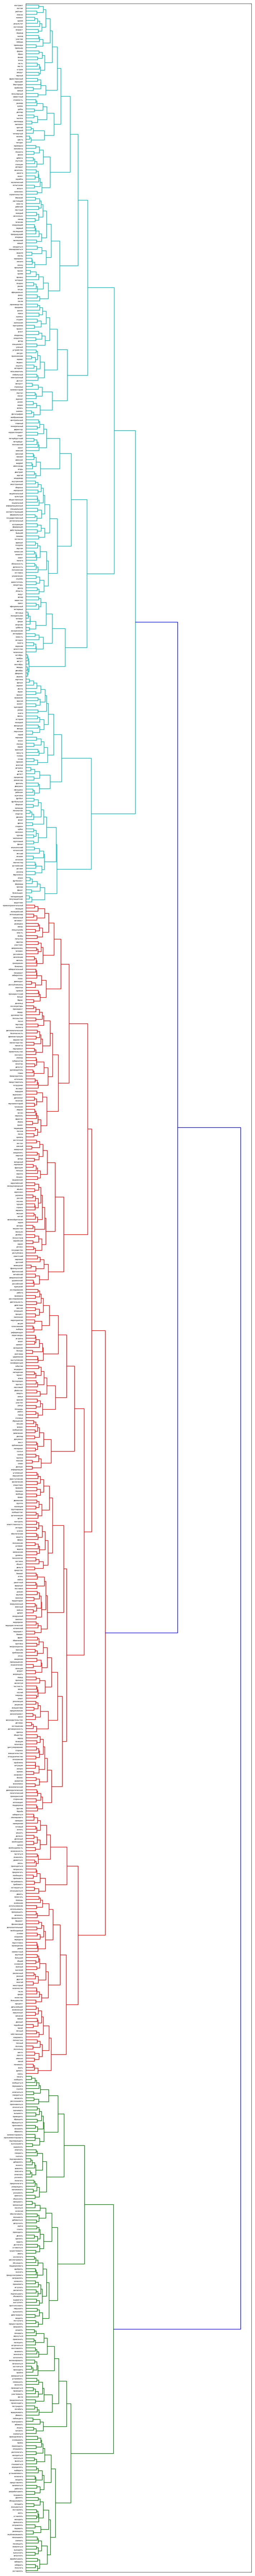

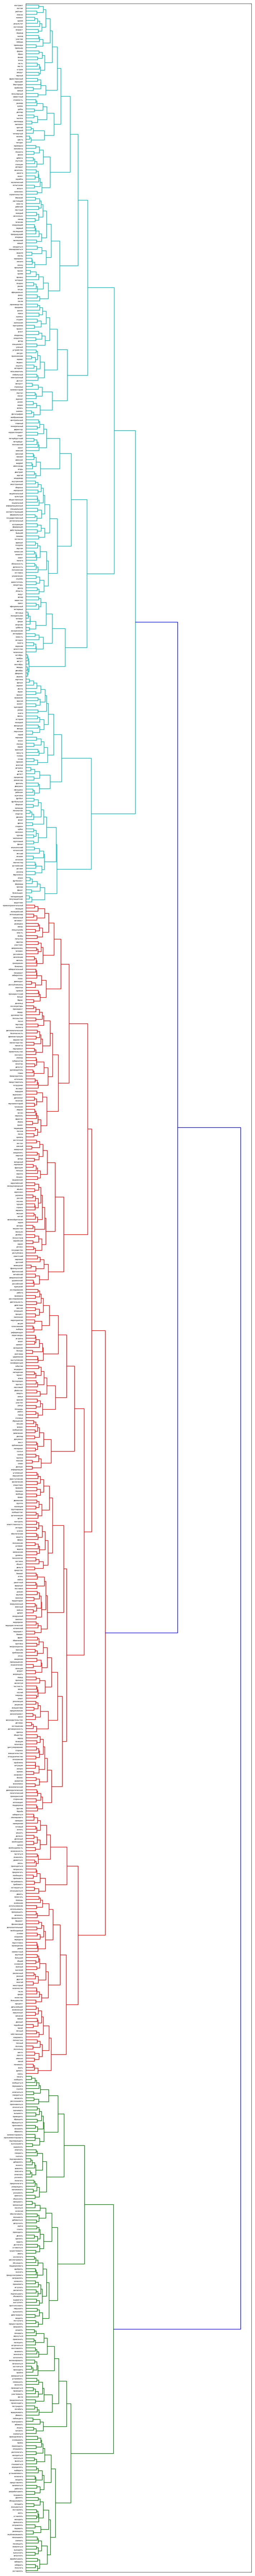

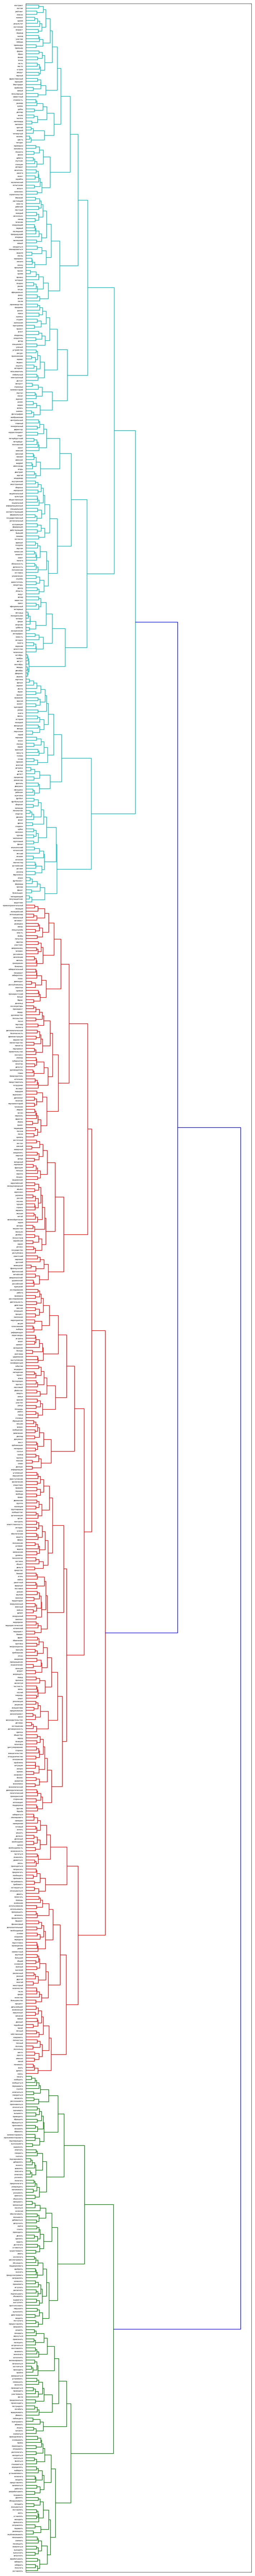

In [94]:
dist = 1 - cosine_similarity(top_words_vec)
linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(10, 100)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=top_words);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() 
plt.show()
plt.savefig('w2v_cluster.png', dpi=200) #save figure as ward_clusters

__Классификация__

In [135]:
def sent_to_vec(sent, w2v = model):
    vec = np.array([w2v[w] for w in sent if w in w2v])
    if len(vec):
        return(np.mean(vec, axis=0))
    else:
        return(np.zeros(100))

In [177]:
data = df[df.tags.isin(['Политика', 'Интернет'])][['lemmas', 'tags']]
data.shape

(41165, 2)

In [178]:
warnings.filterwarnings(action='once')
%time data['mean_vec'] = data.lemmas.apply(lambda x: sent_to_vec(x))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


CPU times: user 55.9 s, sys: 3.95 s, total: 59.9 s
Wall time: 1min 2s


In [179]:
data.head(3)

,lemmas,tags,mean_vec
3,"[с, начало, расследование, российский, вмешате...",Политика,"[-0.19344397, -0.12041502, 0.5827041, 0.553489..."
8,"[минобороны, опубликовывать, видео, полет, рос...",Политика,"[-0.27976137, 0.13583308, 1.1354625, 0.1014967..."
10,"[житель, великобритания, быть, платить, семь, ...",Политика,"[-0.29475698, -0.20564388, 0.29283172, 0.13321..."


In [180]:
np.unique(data.tags)

array(['Интернет', 'Политика'], dtype=object)

Попробуем применить алгоритмы классификации:

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import  train_test_split, GridSearchCV

In [181]:
X = data.mean_vec.tolist()
y = data.tags.tolist()

X, y = np.array(X), np.array(y)
y = (y == 'Политика').astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25)
X_train.shape,  X_test.shape, Y_train.shape, Y_test.shape

((30873, 100), (10292, 100), (30873,), (10292,))

In [183]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

clf = GridSearchCV(LogisticRegression(), hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, Y_train)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 2.7825594022071245


In [184]:
LR = best_model.best_estimator_
preds = LR.predict(X_test)
probas = [p[1] for p in LR.predict_proba(X_test)]
preds[:3], probas[:3]

(array([0, 1, 1]),
 [0.00041223772558510185, 0.9715324779713546, 0.9986396605257992])

In [185]:
print('accuracy: %f' % accuracy_score(Y_test, preds))
print('roc_auc_score: %f' % roc_auc_score(Y_test, probas))
print('precision_score: %f' % precision_score(Y_test, preds))
print('recall_score: %f' % recall_score(Y_test, preds))
print('f1_score: %f' % f1_score(Y_test, preds))

accuracy: 0.976778
roc_auc_score: 0.994048
precision_score: 0.981659
recall_score: 0.989607
f1_score: 0.985617


__Задание:__

Подберите оптимальные параметры для одного или двух других алгоритмов классификации: метода К ближайших соседей или Байесовского классификатора.

In [ ]:
#...

__Задание:__

Напишите функцию sent_to_vec2, которая вычисляет не средний вектор по предложению, а взвешивает слова с соответствущими весами tf-idf. 

In [ ]:
#...

Обучите любой из алгоритмов классификации на полученном датасете:

In [ ]:
#...

__Doc2Vec__

In [192]:
docs = []
j = 0
for i in data.index:
    docs.append(TaggedDocument(data.lemmas[i], str(j)))
    j += 1

In [206]:
docs = np.array(data.lemmas)

tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(docs)]

In [207]:
model = Doc2Vec(size=200, window=5, min_count=5, workers=8, alpha=0.025, min_alpha=0.01, dm=0)
%time model.build_vocab(tagged_data)

CPU times: user 2.65 s, sys: 104 ms, total: 2.75 s
Wall time: 2.79 s


In [208]:
%time model.train(tagged_data, total_examples=len(docs), epochs=20)

CPU times: user 4min 4s, sys: 8.35 s, total: 4min 13s
Wall time: 1min 45s


In [217]:
X_train = [model.docvecs[i] for i in range(len(X_train))]
X_test = [model.docvecs[i] for i in range(len(X_test))]

In [218]:
clf = GridSearchCV(LogisticRegression(), hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, Y_train)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 1.0


In [219]:
LR = best_model.best_estimator_
preds = LR.predict(X_test)
probas = [p[1] for p in LR.predict_proba(X_test)]

In [220]:
print('accuracy: %f' % accuracy_score(Y_test, preds))
print('roc_auc_score: %f' % roc_auc_score(Y_test, probas))
print('precision_score: %f' % precision_score(Y_test, preds))
print('recall_score: %f' % recall_score(Y_test, preds))
print('f1_score: %f' % f1_score(Y_test, preds))

accuracy: 0.804023
roc_auc_score: 0.496695
precision_score: 0.804023
recall_score: 1.000000
f1_score: 0.891366
